In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from bs4 import BeautifulSoup

def read_html_documents(directory_path):
    documents = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                # Parse the HTML content
                soup = BeautifulSoup(content, 'html.parser')
                # Extract information from the HTML document, e.g., title and text content
                title = soup.title.string if soup.title else "No Title"
                text = soup.get_text()
                # Store the information in a structured format, e.g., a dictionary
                document_info = {
                    'file_path': file_path,
                    'title': title,
                    'text_content': text
                }
                documents.append(document_info)
    return documents

# Provide the path to the directory containing the HTML documents
dataset_path = "/content/drive/MyDrive/Major_Project/Project_code/webkb-data/webkb/course"
documents = read_html_documents(dataset_path)

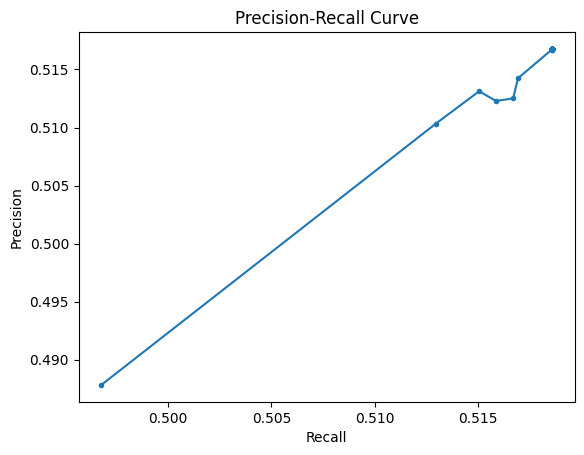

Best precision: 0.5167715789709088
Best recall: 0.5185854246004623


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve

# Function to read HTML documents
def read_html_documents(directory_path):
    documents = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                # Parse the HTML content
                soup = BeautifulSoup(content, 'html.parser')
                # Extract information from the HTML document, e.g., title and text content
                title = soup.title.string if soup.title else "No Title"
                text = soup.get_text()
                # Store the information in a structured format, e.g., a dictionary
                document_info = {
                    'file_path': file_path,
                    'title': title,
                    'text_content': text
                }
                documents.append(document_info)
    return documents

# Function to calculate TF-IDF matrix
def calculate_tfidf(documents):
    texts = [doc['text_content'] for doc in documents]
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

# Particle Swarm Optimization class
class ParticleSwarmOptimization:
    def __init__(self, n_particles, n_iterations, tfidf_matrix, y_true):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.num_features = tfidf_matrix.shape[1]
        self.lower_bound = 0
        self.upper_bound = 1
        self.c1 = 2
        self.c2 = 2
        self.w = 0.7
        self.global_best_position = np.zeros(self.num_features)
        self.global_best_value = float('-inf')
        self.positions = np.random.uniform(self.lower_bound, self.upper_bound, size=(self.n_particles, self.num_features))
        self.velocities = np.random.uniform(-0.1, 0.1, size=(self.n_particles, self.num_features))
        self.tfidf_matrix = tfidf_matrix
        self.y_true = y_true

    # Fitness function to evaluate relevance of documents to query
    def fitness(self, weights):
        weighted_docs = self.tfidf_matrix.multiply(weights)
        similarity_matrix = np.dot(weighted_docs, self.tfidf_matrix.T).toarray()  # Convert to dense array
        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(self.y_true, similarity_matrix[:, 1])
        return np.mean(precision), np.mean(recall)


    # PSO optimization
    def optimize(self):
        precision_list = []
        recall_list = []
        for iteration in range(self.n_iterations):
            for i in range(self.n_particles):
                current_precision, current_recall = self.fitness(self.positions[i])

                # Update global best
                if current_recall > self.global_best_value:
                    self.global_best_value = current_recall
                    self.global_best_position = self.positions[i].copy()

                # Update particle velocity and position
                self.velocities[i] = self.w * self.velocities[i] + \
                                     self.c1 * np.random.rand() * (self.global_best_position - self.positions[i]) + \
                                     self.c2 * np.random.rand() * (self.global_best_position - self.positions[i])
                self.positions[i] = np.clip(self.positions[i] + self.velocities[i], self.lower_bound, self.upper_bound)

            # Store precision and recall for each iteration
            precision_list.append(current_precision)
            recall_list.append(current_recall)

        return precision_list, recall_list

# Main function
if __name__ == "__main__":
    # Provide the path to the directory containing the HTML documents
    dataset_path = "/content/drive/MyDrive/Major_Project/Project_code/webkb-data/webkb/course"
    documents = read_html_documents(dataset_path)

    # Calculate TF-IDF matrix
    tfidf_matrix, vectorizer = calculate_tfidf(documents)

    # Assuming you have relevance labels for documents (binary: relevant or not relevant)
    # Sample y_true creation for demonstration
    y_true = np.random.randint(2, size=(tfidf_matrix.shape[0],))

    # Instantiate PSO object
    pso = ParticleSwarmOptimization(n_particles=30, n_iterations=100, tfidf_matrix=tfidf_matrix, y_true=y_true)

    # Perform PSO optimization to find relevant documents
    precision_list, recall_list = pso.optimize()

    # Plot precision-recall curve for each iteration
    plt.plot(recall_list, precision_list, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Get best precision and recall values
    best_precision = max(precision_list)
    best_recall = max(recall_list)
    print(f'Best precision: {best_precision}')
    print(f'Best recall: {best_recall}')


In [ ]:
import os
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
import warnings

class ParticleSwarmOptimization:
    def __init__(self, n_particles, max_iter, tfidf_matrix, y_true):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.num_features = tfidf_matrix.shape[1]
        self.lower_bound = 0
        self.upper_bound = 1
        self.c1 = 2
        self.c2 = 2
        self.w = 0.7
        self.global_best_position = np.zeros(self.num_features)
        self.global_best_value = float('-inf')
        self.positions = np.random.uniform(self.lower_bound, self.upper_bound, size=(self.n_particles, self.num_features))
        self.velocities = np.random.uniform(-0.1, 0.1, size=(self.n_particles, self.num_features))
        self.tfidf_matrix = tfidf_matrix
        self.y_true = y_true

    # Fitness function to evaluate relevance of documents to query
    def fitness(self, weights):
        weighted_docs = self.tfidf_matrix.multiply(weights)
        similarity_matrix = np.dot(weighted_docs, self.tfidf_matrix.T).toarray()  # Convert to dense array
        # Calculate precision, recall, and F1-score
        y_pred = np.argmax(similarity_matrix, axis=1)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            precision, recall, f1_score, _ = precision_recall_fscore_support(self.y_true, y_pred, average='macro')
        return precision, recall, f1_score

    # PSO optimization
    def optimize(self):
        for iteration in range(self.max_iter):
            for i in range(self.n_particles):
                current_precision, current_recall, _ = self.fitness(self.positions[i])

                if current_precision > self.global_best_value:
                    self.global_best_value = current_precision
                    self.global_best_position = self.positions[i].copy()

                self.velocities[i] = self.w * self.velocities[i] + \
                                     self.c1 * np.random.rand() * (self.global_best_position - self.positions[i]) + \
                                     self.c2 * np.random.rand() * (self.global_best_position - self.positions[i])
                self.positions[i] = np.clip(self.positions[i] + self.velocities[i], self.lower_bound, self.upper_bound)

        return self.global_best_position, self.global_best_value

# Function to read HTML documents
def read_html_documents(directory_path):
    documents = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                # Parse the HTML content
                soup = BeautifulSoup(content, 'html.parser')
                # Extract information from the HTML document, e.g., title and text content
                title = soup.title.string if soup.title else "No Title"
                text = soup.get_text()
                # Store the information in a structured format, e.g., a dictionary
                document_info = {
                    'file_path': file_path,
                    'title': title,
                    'text_content': text
                }
                documents.append(document_info)
    return documents

# Function to calculate TF-IDF matrix
def calculate_tfidf(documents):
    texts = [doc['text_content'] for doc in documents]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

# Main function
if __name__ == "__main__":
    # Provide the path to the directory containing the HTML documents
    dataset_path = "/content/drive/MyDrive/Major_Project/Project_code/webkb-data/webkb/course"
    documents = read_html_documents(dataset_path)

    # Extract labels for evaluation (assuming relevant documents are labeled as 1)
    y_true = np.array([1 if 'relevant' in doc['file_path'] else 0 for doc in documents])

    # Calculate TF-IDF matrix
    tfidf_matrix = calculate_tfidf(documents)

    # Get user query
    user_query = input("Enter your query: ")

    # Transform user query into TF-IDF vector
    vectorizer = TfidfVectorizer()
    query_vector = vectorizer.fit_transform([user_query])

    # Instantiate PSO object
    pso = ParticleSwarmOptimization(n_particles=30, max_iter=100, tfidf_matrix=tfidf_matrix, y_true=y_true)

    # Perform PSO optimization to find relevant documents
    optimized_weights, best_precision = pso.optimize()

    # Calculate relevance scores of documents based on optimized weights
    weighted_docs = tfidf_matrix.multiply(optimized_weights)
    similarity_matrix = np.dot(weighted_docs, tfidf_matrix.T).toarray()
    relevance_scores = similarity_matrix[:, 1]  # Assuming relevant documents are in the second column

    # Sort documents by relevance score
    sorted_indices = np.argsort(relevance_scores)[::-1]  # Reverse sorting to get descending order

    # Display top relevant documents
    top_n = 10
    print(f"Top {top_n} relevant documents:")
    for i in range(top_n):
        idx = sorted_indices[i]
        doc = documents[idx]
        score = relevance_scores[idx]
        print(f"{i+1}. Title: {doc['title']}, Relevance Score: {score:.4f}")

Enter your query: CSI
Top 10 relevant documents:
1. Title: 301 Moved Permanently, Relevance Score: 0.4815
2. Title: 301 Moved Permanently, Relevance Score: 0.4743
3. Title: 301 Moved Permanently, Relevance Score: 0.4696
4. Title: 301 Moved Permanently, Relevance Score: 0.4642
5. Title: 301 Moved Permanently, Relevance Score: 0.4589
6. Title: 301 Moved Permanently, Relevance Score: 0.4579
7. Title: 301 Moved Permanently, Relevance Score: 0.4576
8. Title: CSE 531 Home Page , Relevance Score: 0.0767
9. Title: No Title, Relevance Score: 0.0736
10. Title: No Title, Relevance Score: 0.0699


In [ ]:
import os
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
import warnings

class ParticleSwarmOptimization:
    def __init__(self, n_particles, max_iter, tfidf_matrix, y_true):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.num_features = tfidf_matrix.shape[1]
        self.lower_bound = 0
        self.upper_bound = 1
        self.c1 = 2
        self.c2 = 2
        self.w = 0.7
        self.global_best_position = np.zeros(self.num_features)
        self.global_best_value = float('-inf')
        self.positions = np.random.uniform(self.lower_bound, self.upper_bound, size=(self.n_particles, self.num_features))
        self.velocities = np.random.uniform(-0.1, 0.1, size=(self.n_particles, self.num_features))
        self.tfidf_matrix = tfidf_matrix
        self.y_true = y_true

    # Fitness function to evaluate relevance of documents to query
    def fitness(self, weights):
        weighted_docs = self.tfidf_matrix.multiply(weights)
        similarity_matrix = np.dot(weighted_docs, self.tfidf_matrix.T).toarray()  # Convert to dense array
        # Calculate precision, recall, and F1-score
        y_pred = np.argmax(similarity_matrix, axis=1)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            precision, recall, f1_score, _ = precision_recall_fscore_support(self.y_true, y_pred, average='macro')
        return precision, recall, f1_score

    # PSO optimization
    def optimize(self):
        for iteration in range(self.max_iter):
            for i in range(self.n_particles):
                current_precision, current_recall, _ = self.fitness(self.positions[i])

                if current_precision > self.global_best_value:
                    self.global_best_value = current_precision
                    self.global_best_position = self.positions[i].copy()

                self.velocities[i] = self.w * self.velocities[i] + \
                                     self.c1 * np.random.rand() * (self.global_best_position - self.positions[i]) + \
                                     self.c2 * np.random.rand() * (self.global_best_position - self.positions[i])
                self.positions[i] = np.clip(self.positions[i] + self.velocities[i], self.lower_bound, self.upper_bound)

        return self.global_best_position, self.global_best_value

# Function to read HTML documents
def read_html_documents(directory_path):
    documents = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                # Parse the HTML content
                soup = BeautifulSoup(content, 'html.parser')
                # Extract information from the HTML document, e.g., title and text content
                title = soup.title.string if soup.title else "No Title"
                text = soup.get_text()
                # Store the information in a structured format, e.g., a dictionary
                document_info = {
                    'file_path': file_path,
                    'title': title,
                    'text_content': text
                }
                documents.append(document_info)
    return documents

# Function to calculate TF-IDF matrix
def calculate_tfidf(documents):
    texts = [doc['text_content'] for doc in documents]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

# Main function
if __name__ == "__main__":
    # Provide the path to the directory containing the HTML documents
    dataset_path = "/content/drive/MyDrive/Major_Project/Project_code/webkb-data/webkb/course"
    documents = read_html_documents(dataset_path)

    # Extract labels for evaluation (assuming relevant documents are labeled as 1)
    y_true = np.array([1 if 'relevant' in doc['file_path'] else 0 for doc in documents])

    # Calculate TF-IDF matrix
    tfidf_matrix = calculate_tfidf(documents)

    # Get user query
    user_query = input("Enter your query: ")

    # Transform user query into TF-IDF vector
    vectorizer = TfidfVectorizer()
    query_vector = vectorizer.fit_transform([user_query])

    # Instantiate PSO object
    pso = ParticleSwarmOptimization(n_particles=30, max_iter=100, tfidf_matrix=tfidf_matrix, y_true=y_true)

    # Perform PSO optimization to find relevant documents
    optimized_weights, best_precision = pso.optimize()

    # Calculate relevance scores of documents based on optimized weights
    weighted_docs = tfidf_matrix.multiply(optimized_weights)
    similarity_matrix = np.dot(weighted_docs, tfidf_matrix.T).toarray()
    relevance_scores = similarity_matrix[:, 1]  # Assuming relevant documents are in the second column

    # Sort documents by relevance score
    sorted_indices = np.argsort(relevance_scores)[::-1]  # Reverse sorting to get descending order

    # Display top relevant documents
    top_n = 10
    print(f"Top {top_n} relevant documents:")
    for i in range(top_n):
        idx = sorted_indices[i]
        doc = documents[idx]
        score = relevance_scores[idx]
        print(f"{i+1}. Title: {doc['title']}, Relevance Score: {score:.4f}")

    # Calculate precision, recall, and F1-score
    y_pred = np.zeros_like(y_true)
    y_pred[sorted_indices[:top_n]] = 1  # Consider top_n documents as relevant
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    print("Macro-averaged Precision:", precision)
    print("Macro-averaged Recall:", recall)
    print("Macro-averaged F1-score:", f1_score)


Enter your query: CSI
Top 10 relevant documents:
1. Title: 301 Moved Permanently, Relevance Score: 0.7949
2. Title: 301 Moved Permanently, Relevance Score: 0.7423
3. Title: 301 Moved Permanently, Relevance Score: 0.7348
4. Title: 301 Moved Permanently, Relevance Score: 0.7267
5. Title: 301 Moved Permanently, Relevance Score: 0.7264
6. Title: 301 Moved Permanently, Relevance Score: 0.7181
7. Title: 301 Moved Permanently, Relevance Score: 0.7160
8. Title: CSE 531 Home Page , Relevance Score: 0.0822
9. Title: www course home page, Relevance Score: 0.0790
10. Title: CSE 590D Home Page (Autumn 1995), Relevance Score: 0.0787
Macro-averaged Precision: 0.5
Macro-averaged Recall: 0.4946236559139785
Macro-averaged F1-score: 0.4972972972972973


In [ ]:
import os
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
import warnings

class ParticleSwarmOptimization:
    def __init__(self, n_particles, max_iter, tfidf_matrix, y_true):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.num_features = tfidf_matrix.shape[1]
        self.lower_bound = 0
        self.upper_bound = 1
        self.c1 = 2
        self.c2 = 2
        self.w = 0.7
        self.global_best_position = np.zeros(self.num_features)
        self.global_best_value = float('-inf')
        self.positions = np.random.uniform(self.lower_bound, self.upper_bound, size=(self.n_particles, self.num_features))
        self.velocities = np.random.uniform(-0.1, 0.1, size=(self.n_particles, self.num_features))
        self.tfidf_matrix = tfidf_matrix
        self.y_true = y_true

    # Fitness function to evaluate relevance of documents to query
    def fitness(self, weights):
        weighted_docs = self.tfidf_matrix.multiply(weights)
        similarity_matrix = np.dot(weighted_docs, self.tfidf_matrix.T).toarray()  # Convert to dense array
        # Calculate precision, recall, and F1-score
        y_pred = np.argmax(similarity_matrix, axis=1)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            precision, recall, f1_score, _ = precision_recall_fscore_support(self.y_true, y_pred, average='macro')
        return precision, recall, f1_score

    # PSO optimization
    def optimize(self):
        for iteration in range(self.max_iter):
            for i in range(self.n_particles):
                current_precision, current_recall, _ = self.fitness(self.positions[i])

                if current_precision > self.global_best_value:
                    self.global_best_value = current_precision
                    self.global_best_position = self.positions[i].copy()

                self.velocities[i] = self.w * self.velocities[i] + \
                                     self.c1 * np.random.rand() * (self.global_best_position - self.positions[i]) + \
                                     self.c2 * np.random.rand() * (self.global_best_position - self.positions[i])
                self.positions[i] = np.clip(self.positions[i] + self.velocities[i], self.lower_bound, self.upper_bound)

        return self.global_best_position, self.global_best_value

# Function to read HTML documents
def read_html_documents(directory_path):
    documents = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                # Parse the HTML content
                soup = BeautifulSoup(content, 'html.parser')
                # Extract information from the HTML document, e.g., title and text content
                title = soup.title.string if soup.title else "No Title"
                text = soup.get_text()
                # Store the information in a structured format, e.g., a dictionary
                document_info = {
                    'file_path': file_path,
                    'title': title,
                    'text_content': text
                }
                documents.append(document_info)
    return documents

# Function to calculate TF-IDF matrix
def calculate_tfidf(documents):
    texts = [doc['text_content'] for doc in documents]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

# Main function
if __name__ == "__main__":
    # Provide the path to the directory containing the HTML documents
    dataset_path = "/content/drive/MyDrive/Major_Project/Project_code/webkb-data/webkb"
    documents = read_html_documents(dataset_path)

    # Extract labels for evaluation (assuming relevant documents are labeled as 1)
    y_true = np.array([1 if 'relevant' in doc['file_path'] else 0 for doc in documents])

    # Calculate TF-IDF matrix
    tfidf_matrix = calculate_tfidf(documents)

    # Get user query
    user_query = input("Enter your query: ")

    # Transform user query into TF-IDF vector
    vectorizer = TfidfVectorizer()
    query_vector = vectorizer.fit_transform([user_query])

    # Instantiate PSO object
    pso = ParticleSwarmOptimization(n_particles=30, max_iter=100, tfidf_matrix=tfidf_matrix, y_true=y_true)

    # Perform PSO optimization to find relevant documents
    optimized_weights, best_precision = pso.optimize()

    # Calculate relevance scores of documents based on optimized weights
    weighted_docs = tfidf_matrix.multiply(optimized_weights)
    similarity_matrix = np.dot(weighted_docs, tfidf_matrix.T).toarray()
    relevance_scores = similarity_matrix[:, 1]  # Assuming relevant documents are in the second column

    # Sort documents by relevance score
    sorted_indices = np.argsort(relevance_scores)[::-1]  # Reverse sorting to get descending order

    # Display top relevant documents
    top_n = 10
    print(f"Top {top_n} relevant documents:")
    for i in range(top_n):
        idx = sorted_indices[i]
        doc = documents[idx]
        score = relevance_scores[idx]
        print(f"{i+1}. Title: {doc['title']}, Relevance Score: {score:.4f}")

<ipython-input-4-036e26741ebf>:63: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(content, 'html.parser')


In [ ]:
import os
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve

class ParticleSwarmOptimization:
    def __init__(self, n_particles, max_iter, tfidf_matrix, y_true):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.num_features = tfidf_matrix.shape[1]
        self.lower_bound = 0
        self.upper_bound = 1
        self.c1 = 2
        self.c2 = 2
        self.w = 0.7
        self.global_best_position = np.zeros(self.num_features)
        self.global_best_value = float('-inf')
        self.positions = np.random.uniform(self.lower_bound, self.upper_bound, size=(self.n_particles, self.num_features))
        self.velocities = np.random.uniform(-0.1, 0.1, size=(self.n_particles, self.num_features))
        self.tfidf_matrix = tfidf_matrix
        self.y_true = y_true

    # Fitness function to evaluate relevance of documents to query
    def fitness(self, weights):
        weighted_docs = self.tfidf_matrix.multiply(weights)
        similarity_matrix = np.dot(weighted_docs, self.tfidf_matrix.T).toarray()  # Convert to dense array
        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(self.y_true, similarity_matrix[:, 1])
        return np.mean(precision), np.mean(recall)

    # PSO optimization
    def optimize(self):
        for iteration in range(self.max_iter):
            for i in range(self.n_particles):
                current_precision, current_recall = self.fitness(self.positions[i])

                if current_precision > self.global_best_value:
                    self.global_best_value = current_precision
                    self.global_best_position = self.positions[i].copy()

                self.velocities[i] = self.w * self.velocities[i] + \
                                     self.c1 * np.random.rand() * (self.global_best_position - self.positions[i]) + \
                                     self.c2 * np.random.rand() * (self.global_best_position - self.positions[i])
                self.positions[i] = np.clip(self.positions[i] + self.velocities[i], self.lower_bound, self.upper_bound)

        return self.global_best_position, self.global_best_value

# Function to read HTML documents
def read_html_documents(directory_path):
    documents = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                # Parse the HTML content
                soup = BeautifulSoup(content, 'html.parser')
                # Extract information from the HTML document, e.g., title and text content
                title = soup.title.string if soup.title else "No Title"
                text = soup.get_text()
                # Store the information in a structured format, e.g., a dictionary
                document_info = {
                    'file_path': file_path,
                    'title': title,
                    'text_content': text
                }
                documents.append(document_info)
    return documents

# Function to calculate TF-IDF matrix
def calculate_tfidf(documents):
    texts = [doc['text_content'] for doc in documents]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

# Main function
if __name__ == "__main__":
    # Provide the path to the directory containing the HTML documents
    dataset_path = "/content/drive/MyDrive/Major_Project/Project_code/webkb-data/webkb/course"
    documents = read_html_documents(dataset_path)

    # Extract labels for evaluation (assuming relevant documents are labeled as 1)
    y_true = np.array([1 if 'relevant' in doc['file_path'] else 0 for doc in documents])

    # Calculate TF-IDF matrix
    tfidf_matrix = calculate_tfidf(documents)

    # Get user query
    user_query = input("Enter your query: ")

    # Transform user query into TF-IDF vector
    vectorizer = TfidfVectorizer()
    query_vector = vectorizer.fit_transform([user_query])

    # Instantiate PSO object
    pso = ParticleSwarmOptimization(n_particles=30, max_iter=100, tfidf_matrix=tfidf_matrix, y_true=y_true)

    # Perform PSO optimization to find relevant documents
    optimized_weights, best_precision = pso.optimize()

    # Calculate relevance scores of documents based on optimized weights
    weighted_docs = tfidf_matrix.multiply(optimized_weights)
    similarity_matrix = np.dot(weighted_docs, tfidf_matrix.T).toarray()
    relevance_scores = similarity_matrix[:, 1]  # Assuming relevant documents are in the second column

    # Sort documents by relevance score
    sorted_indices = np.argsort(relevance_scores)[::-1]  # Reverse sorting to get descending order

    # Display top relevant documents
    top_n = 10
    print(f"Top {top_n} relevant documents:")
    for i in range(top_n):
        idx = sorted_indices[i]
        doc = documents[idx]
        score = relevance_scores[idx]
        print(f"{i+1}. URL: {doc['file_path']}, Relevance Score: {score:.4f}, Precision: {best_precision:.4f}")
